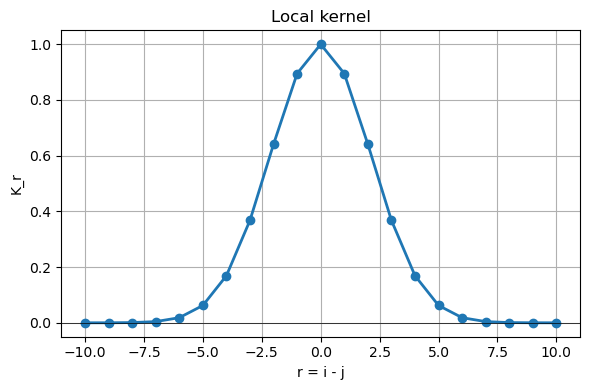

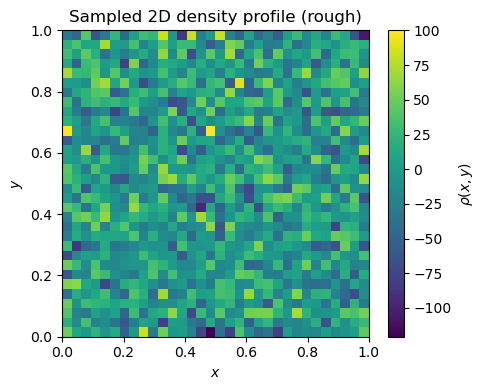

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 100
N_epochs = 10000
lr = 1e-2 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 50    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # padding mode for convolution-based routines: either "zero" or "reflect"
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250

# grid and basis settings
N_x = 32 # number of grid points in x direction
N_y = N_x # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "rough" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 10 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# interaction kernel parameters
kernel_regime = "single_Gaussian" # "single_Gaussian" or "double_Gaussian" 
if kernel_regime == "single_Gaussian":
    amp_Gaussian = 1.0 # amplitude of Gaussian kernel for interaction energy
    sigma_Gaussian = 3.0 # width of Gaussian kernel for interaction energy
elif kernel_regime == "double_Gaussian":
    amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
    sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
    amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
    sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")

if kernel_regime == "single_Gaussian" and pad_mode == "zero":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return amp_Gaussian * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian, pad_mode=pad_mode)
elif kernel_regime == "single_Gaussian" and pad_mode == "reflect":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return amp_Gaussian * E_int_rs_dct(rho, kernel="gaussian", sigma=sigma_Gaussian)
elif kernel_regime == "double_Gaussian" and pad_mode == "zero":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return (amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode=pad_mode) +
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode=pad_mode))
elif kernel_regime == "double_Gaussian" and pad_mode == "reflect":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return (amp_Gaussian_1 * E_int_rs_dct(rho, kernel="gaussian", sigma=sigma_Gaussian_1) +
                amp_Gaussian_2 * E_int_rs_dct(rho, kernel="gaussian", sigma=sigma_Gaussian_2))

# generate train/test split
flag_generate_data = False # if True, generate new data; if False, load existing data from disk
if flag_generate_data:
    N_batch = 10
    torch.manual_seed(1234) # for reproducibility
    rho_train, d_rho_x_train, d_rho_y_train, a_train, targets_train = generate_data_2d(N_train, N_batch, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
    rho_test, d_rho_x_test, d_rho_y_test, a_test, targets_test = generate_data_2d(N_test, N_batch, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
    rho_val, d_rho_x_val, d_rho_y_val, a_val, targets_val = generate_data_2d(N_val, N_batch, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  
    # save data to disk
    os.makedirs("DATA2d", exist_ok=True)
    torch.save(
        {
            "rho_train": rho_train,
            "d_rho_x_train": d_rho_x_train,
            "d_rho_y_train": d_rho_y_train,
            "a_train": a_train,
            "targets_train": targets_train,
            "rho_val": rho_val,
            "d_rho_x_val": d_rho_x_val,
            "d_rho_y_val": d_rho_y_val,
            "a_val": a_val,
            "targets_val": targets_val,
            "rho_test": rho_test,
            "d_rho_x_test": d_rho_x_test,
            "d_rho_y_test": d_rho_y_test,
            "a_test": a_test,
            "targets_test": targets_test,
            "data_regime": data_regime,
            "kernel_regime": kernel_regime,
        },
        f"DATA2d/dataset_{data_regime}_{kernel_regime}_{N_x}_{N_y}.pt",
    )
    N_batch = 100
else:
    # load data from disk
    data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{N_x}_{N_y}.pt")
    rho_train = data["rho_train"]
    targets_train = data["targets_train"]
    rho_test = data["rho_test"]
    targets_test = data["targets_test"]
    rho_val = data["rho_val"]
    targets_val = data["targets_val"]

features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_feat)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


# visualize the interaction kernel
R = 10 
r_grid = torch.arange(-R, R+1)
plt.figure(figsize=(6,4))
if kernel_regime == "single_Gaussian":
    plt.plot(r_grid, amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian), 'o-', linewidth=2)
elif kernel_regime == "double_Gaussian":
    plt.plot(r_grid, amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2), 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Local kernel")
plt.grid(True)
plt.tight_layout()
plt.show()

# visualize a sampled density profile
rho_batch, _, _ , a_batch = sample_density_batch(N_batch, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
rho_np = rho_batch[0, :, :].detach().cpu().numpy()
plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_np.T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()

In [ ]:
flag_train = False # set to True to train models
learning_regime = "rs_window"
ckpt_dir = "LearningLocalKernel2d_checkpoints"
R_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if flag_train:
    if learning_regime == "rs_window":
        for R in R_list:

            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f'_{N_x}_{N_y}'
            torch.manual_seed(1234) # for reproducibility

            model = RSKernelOnlyEnergyNN(
                R=R, 
                pad_mode=pad_mode,
                mean_feat=mean_feat,
                std_feat=std_feat,
                E_mean=E_mean,
                E_std=E_std,
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Reduce LR when val loss plateaus
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
            )


            hist, best_epoch = train_with_early_stopping(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                max_epochs=N_epochs,
                patience=patience,
                min_delta=min_delta,
                ckpt_dir=ckpt_dir,
                run_name=run_name,
                learning_regime=learning_regime,
                N_x=N_x,
                N_y=N_y,
                device=device,
            )


[0001] train=26.966007 | val=22.729495 | best_val=22.729495 (epoch 1)
[0010] train=1.573152 | val=1.297863 | best_val=1.297863 (epoch 10)
[0020] train=0.468708 | val=0.499654 | best_val=0.499654 (epoch 20)
[0030] train=0.451844 | val=0.488430 | best_val=0.488117 (epoch 28)
[0040] train=0.451895 | val=0.488096 | best_val=0.487788 (epoch 38)
[0050] train=0.451711 | val=0.488323 | best_val=0.487422 (epoch 49)
[0060] train=0.451852 | val=0.487797 | best_val=0.487422 (epoch 49)
[0070] train=0.451924 | val=0.487890 | best_val=0.487422 (epoch 49)
[0080] train=0.451893 | val=0.487615 | best_val=0.487422 (epoch 49)
[0090] train=0.451868 | val=0.488335 | best_val=0.487208 (epoch 83)
[0100] train=0.451757 | val=0.488360 | best_val=0.487174 (epoch 95)
[0110] train=0.451803 | val=0.488225 | best_val=0.487174 (epoch 95)
[0120] train=0.451684 | val=0.488585 | best_val=0.487174 (epoch 95)
[0130] train=0.451719 | val=0.488494 | best_val=0.487174 (epoch 95)
[0140] train=0.451773 | val=0.488016 | best_va

   epoch  train_loss   val_loss
0      1   20.034114  11.193872
1      2    7.859871   5.489157
2      3    4.094550   3.092601
3      4    2.144810   1.571775
4      5    1.120505   0.852964


<Axes: title={'center': 'loc_window_kernel_10_rough_single_Gaussian_32_32'}, xlabel='epoch'>

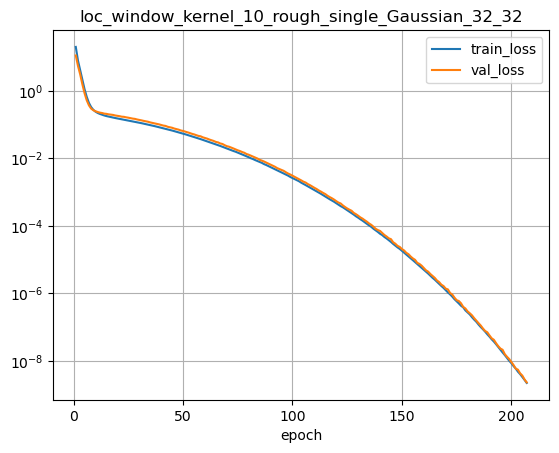

In [3]:
if learning_regime == "rs_window":
    R = 10
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f'_{N_x}_{N_y}'


path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

Model loc_window_kernel_1_rough_single_Gaussian_32_32: best val loss = 0.487174 at epoch 95
Best model: R=1, val_loss=0.487174
Model loc_window_kernel_2_rough_single_Gaussian_32_32: best val loss = 0.158700 at epoch 135
Best model: R=2, val_loss=0.158700
Model loc_window_kernel_3_rough_single_Gaussian_32_32: best val loss = 0.031590 at epoch 146
Best model: R=3, val_loss=0.031590
Model loc_window_kernel_4_rough_single_Gaussian_32_32: best val loss = 0.003630 at epoch 208
Best model: R=4, val_loss=0.003630
Model loc_window_kernel_5_rough_single_Gaussian_32_32: best val loss = 0.000354 at epoch 160
Best model: R=5, val_loss=0.000354
Model loc_window_kernel_6_rough_single_Gaussian_32_32: best val loss = 0.000023 at epoch 169
Best model: R=6, val_loss=0.000023
Model loc_window_kernel_7_rough_single_Gaussian_32_32: best val loss = 0.000011 at epoch 164
Best model: R=7, val_loss=0.000011
Model loc_window_kernel_8_rough_single_Gaussian_32_32: best val loss = 0.000003 at epoch 168
Best model: 

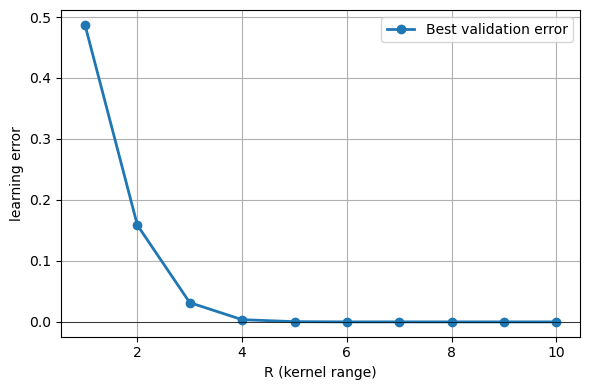

In [4]:
if learning_regime == "rs_window":
    R_best = 0
    best_val = math.inf

    val_hist_R = []
    learning_hist_R = []

    for R in R_list:
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f'_{N_x}_{N_y}'

        model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", RSKernelOnlyEnergyNN, device=device)

        val_hist_R.append((R, val_loss))
        learning_hist_R.append((R, ))

        print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
        if val_loss < best_val:
            best_val = val_loss
            R_best = R

        print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

    print("Validation history:")
    for R, val_loss in val_hist_R:
        print(f"R={R}: val_loss={val_loss:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot([x[0] for x in val_hist_R], [x[1] for x in val_hist_R], 'o-', label='Best validation error', linewidth=2)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel("R (kernel range)")
    plt.ylabel("learning error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

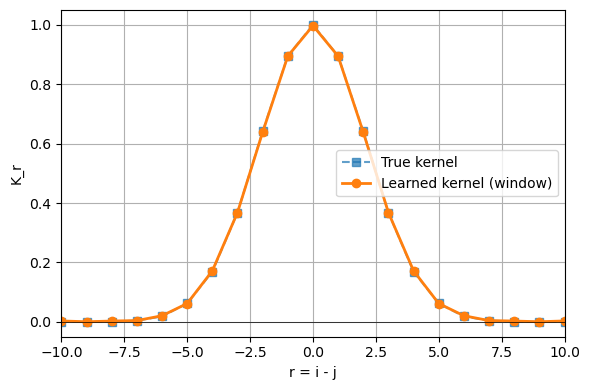

In [5]:
flag_window = True # set to True to visualize window-based kernel
R = 10
# Original true kernel
r_grid = np.arange(-R, R+1)
if kernel_regime == "single_Gaussian":
    def K_true(r):
        return amp_Gaussian * np.exp(-(r**2) / (sigma_Gaussian**2))
elif kernel_regime == "double_Gaussian":
    def K_true(r):
        return (amp_Gaussian_1 * np.exp(-(r**2) / (sigma_Gaussian_1**2)) +
                amp_Gaussian_2 * np.exp(-(r**2) / (sigma_Gaussian_2**2)))
k_true = K_true(r_grid)

if flag_window:
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f'_{N_x}_{N_y}'
    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", RSKernelOnlyEnergyNN, device=device)
    with torch.no_grad():
        k_full = model.kernel_conv.build_kernel().cpu().numpy().squeeze() 

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
if flag_window:
    plt.plot(r_grid, k_full[:, R] , 'o-', label='Learned kernel (window)', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


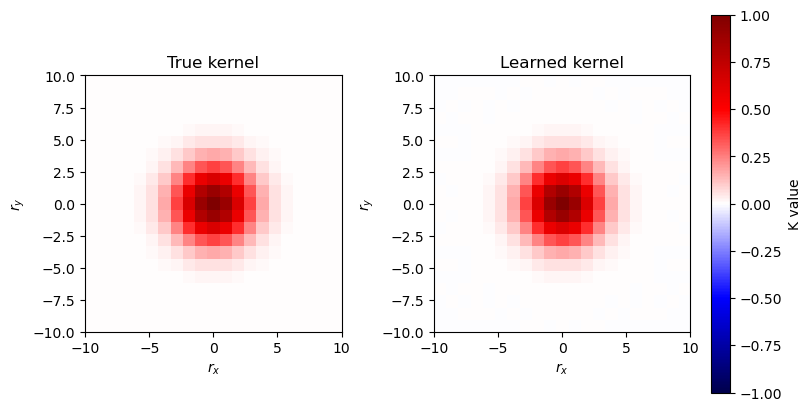

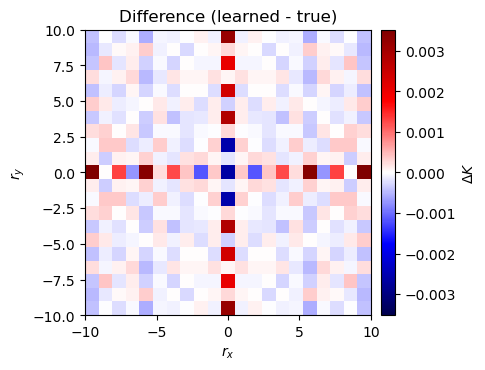

In [6]:
# 2D visualization of learned vs true kernel
coords = torch.arange(-R, R+1, device=device, dtype=dtype)  # [-R, ..., R]
rx, ry = torch.meshgrid(coords, coords, indexing="ij")      # (2R+1, 2R+1)
r = torch.sqrt(rx**2 + ry**2)                               # radial distance
K_true_2d = K_true(r)                                       # (2R+1, 2R+1)

K_true_np = K_true_2d.detach().cpu().numpy()
K_diff_np  = (k_full - K_true_np)

# symmetric color scale for fair comparison
vmax = max(np.abs(K_true_np).max(), np.abs(k_full).max())
vmax_diff = np.abs(K_diff_np).max()
extent = [-R, R, -R, R]

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    constrained_layout=True  # lets matplotlib handle spacing nicely
)

# --- True kernel ---
im0 = axes[0].imshow(
    K_true_np,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[0].set_title("True kernel")
axes[0].set_xlabel(r"$r_x$")
axes[0].set_ylabel(r"$r_y$")

# --- Learned kernel ---
im1 = axes[1].imshow(
    k_full,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[1].set_title("Learned kernel")
axes[1].set_xlabel(r"$r_x$")
axes[1].set_ylabel(r"$r_y$")

cbar = fig.colorbar(
    im1,
    ax=axes,
    location="right",
    fraction=0.04,  # width
    pad=0.02         # distance from rightmost axes
)
cbar.set_label("K value")

plt.show()

fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(
    K_diff_np,
    origin="lower",
    extent=extent,
    vmin=-np.abs(K_diff_np).max(),
    vmax= np.abs(K_diff_np).max(),
    cmap="seismic"
)
ax.set_title("Difference (learned - true)")
ax.set_xlabel(r"$r_x$")
ax.set_ylabel(r"$r_y$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Delta K$")

plt.show()